# Part 1

In [1]:
!pip install gensim
!pip install -q transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.4 MB/s eta 0:00:00


In [29]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
import re
import time
import torch
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset, DatasetDict
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt_tab')
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
songs = [
    open("song_1.txt").read(),
    open("song_2.txt").read(),
    open("song_3.txt").read()
]

Text preprocessing: lowering, tokenizing, remove numbers, remove english stopwords, lemmatize and connect again

In [4]:
stop_words = set(stopwords.words("english"))
lemm = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemm.lemmatize(t) for t in tokens]
    return " ".join(tokens)

clean_songs = [preprocess(s) for s in songs]


In [5]:
for i, txt in enumerate(clean_songs, 1):
    print(f"\nSong {i}:\n", txt[:300], "...")


Song 1:
 four hundred thousand year ago came outer space gave u life taking everything granted think see smoke around feel like humankind feel like glacier eye mountain head heart ocean feel alone everybody wrong feel living thing call hate inside get world none rebuild disabled land evolving eye shut vision ...

Song 2:
 wave finger must outta head eye hole deep muddy water practically raised dead rob grave snow cradle burn evidence soapbox house card glass go tossin stone around must high must high must foot mouth head whatcha talkin difficult dance one pull boy must high must high steal borrow refer save shady inf ...

Song 3:
 world insane think strange love wan na know brain life injected something expected smile affection made soul connection bell toll cold show soul sentimental gentleman afraid show best friend show soul world insane think strange love wan na know brain yes find appealing show feeling friend need kneel ...


TF-IDF implementation

In [7]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(clean_songs)

terms = vectorizer.get_feature_names_out()

In [8]:
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=terms,
                  index=[f"Song {i+1}" for i in range(len(songs))])

print("TF-IDF matrix")
display(tfidf_df.iloc[:, :20])

TF-IDF matrix


,affection,afraid,ago,alone,already,always,appealing,around,ball,believed,bell,best,black,borrow,boy,brain,burn,call,came,card
Song 1,0.000000,0.000000,0.079522,0.079522,0.079522,0.159043,0.000000,0.060478,0.000000,0.079522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079522,0.079522,0.000000
Song 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032197,0.084669,0.000000,0.000000,0.000000,0.127004,0.042335,0.042335,0.000000,0.042335,0.000000,0.000000,0.042335
Song 3,0.058628,0.175885,0.000000,0.000000,0.000000,0.000000,0.058628,0.000000,0.000000,0.000000,0.058628,0.234514,0.000000,0.000000,0.000000,0.175885,0.000000,0.000000,0.000000,0.000000


In [9]:
N = 20
top_terms = tfidf_df.sum(axis=0).sort_values(ascending=False).head(N)
top_tfidf_df = tfidf_df[top_terms.index]

print("Top 20 words by total TF-IDF score")
display(top_tfidf_df)

Top 20 words by total TF-IDF score


,must,show,soul,eye,feel,high,growing,friend,world,know,best,see,shade,indigo,love,think,head,na,insane,need
Song 1,0.000000,0.000000,0.000000,0.181434,0.397608,0.000000,0.318086,0.000000,0.120956,0.000000,0.000000,0.181434,0.000000,0.000000,0.060478,0.060478,0.120956,0.000000,0.000000,0.000000
Song 2,0.508015,0.032197,0.000000,0.225376,0.000000,0.381011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211673,0.211673,0.000000,0.000000,0.064393,0.000000,0.000000,0.000000
Song 3,0.000000,0.445884,0.410399,0.000000,0.000000,0.000000,0.000000,0.293142,0.133765,0.234514,0.234514,0.044588,0.000000,0.000000,0.133765,0.133765,0.000000,0.175885,0.175885,0.175885


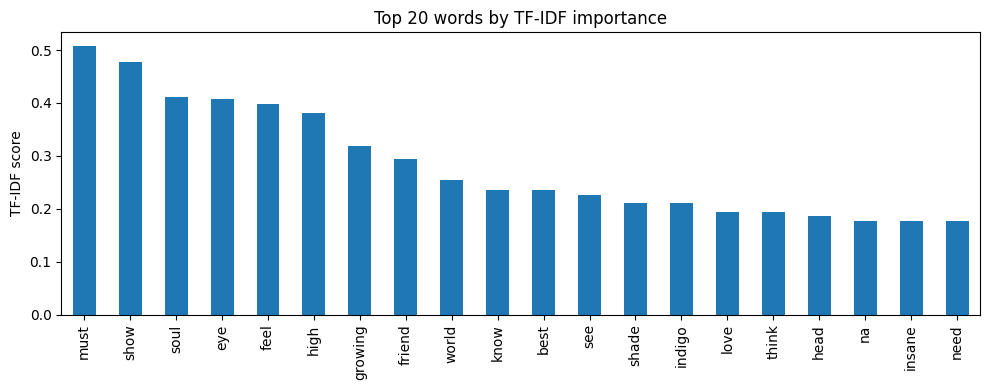

In [10]:
plt.figure(figsize=(10,4))
top_terms.plot(kind="bar")
plt.title("Top 20 words by TF-IDF importance")
plt.ylabel("TF-IDF score")
plt.tight_layout()
plt.show()

Words that are most unique for one song and there are a lot of such words in the texts have hight importance

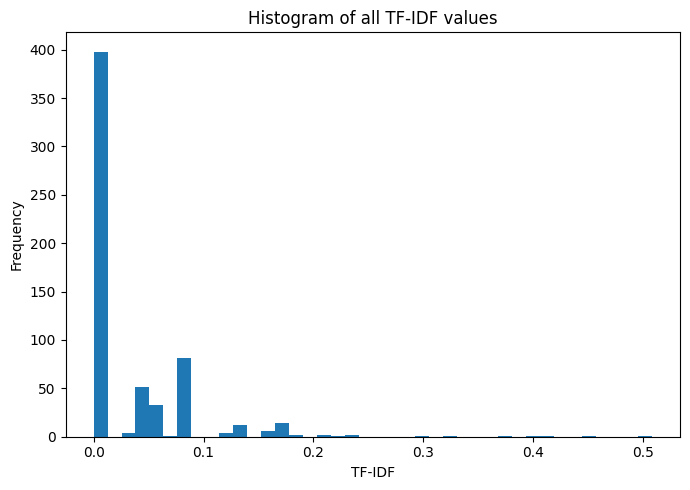

In [11]:
plt.figure(figsize=(7,5))
plt.hist(tfidf_df.values.flatten(), bins=40)
plt.title("Histogram of all TF-IDF values")
plt.xlabel("TF-IDF")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The most of the words have zero importance because they are general , and only a few words have high importance

In [12]:
tfidf_df

,affection,afraid,ago,alone,already,always,appealing,around,ball,believed,...,weeping,whatcha,within,without,wo,world,wrong,ya,year,yes
Song 1,0.000000,0.000000,0.079522,0.079522,0.079522,0.159043,0.000000,0.060478,0.000000,0.079522,...,0.000000,0.000000,0.079522,0.000000,0.000000,0.120956,0.079522,0.000000,0.079522,0.000000
Song 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032197,0.084669,0.000000,...,0.127004,0.042335,0.000000,0.042335,0.000000,0.000000,0.000000,0.042335,0.000000,0.000000
Song 3,0.058628,0.175885,0.000000,0.000000,0.000000,0.000000,0.058628,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.058628,0.133765,0.000000,0.000000,0.000000,0.058628


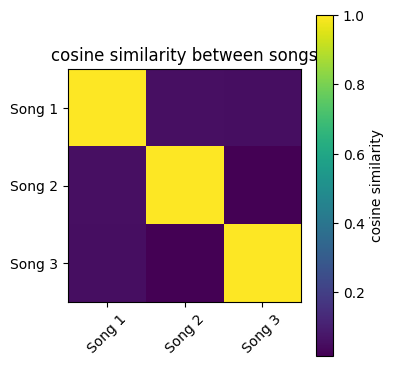

In [30]:
sim_matrix_tfidf = cosine_similarity(tfidf_df)

n = len(tfidf_df)
song_labels = tfidf_df.index

plt.figure(figsize=(4, 4))
plt.imshow(sim_matrix_tfidf, interpolation="nearest")
plt.title("cosine similarity between songs")
plt.xticks(ticks=range(n), labels=song_labels, rotation=45)
plt.yticks(ticks=range(n), labels=song_labels)
plt.colorbar(label="cosine similarity")
plt.tight_layout()
plt.show()


Cosine similarity between different songs is low

# Part 2

Count vectorizer

Data preparing

In [21]:
song_labels = [f"Song {i+1}" for i in range(len(clean_songs))]

count_vec = CountVectorizer()
X_count = count_vec.fit_transform(clean_songs)

count_vocab = count_vec.get_feature_names_out()

df_count = pd.DataFrame(
    X_count.toarray(),
    index=song_labels,
    columns=count_vocab
)
df_count.shape

(3, 206)

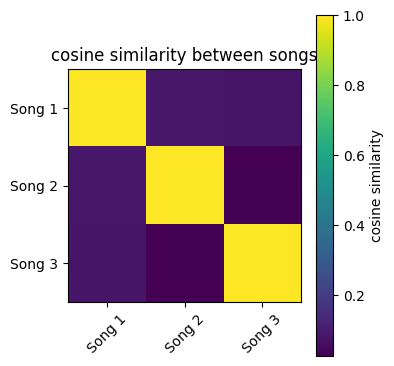

In [31]:
sim_matrix_count = cosine_similarity(df_count)

n = len(df_count)
song_labels = df_count.index

plt.figure(figsize=(4, 4))
plt.imshow(sim_matrix_count, interpolation="nearest")
plt.title("cosine similarity between songs")
plt.xticks(ticks=range(n), labels=song_labels, rotation=45)
plt.yticks(ticks=range(n), labels=song_labels)
plt.colorbar(label="cosine similarity")
plt.tight_layout()
plt.show()

The same as for TF-IDF: cosine similarity between different words is low

Show top 15 words

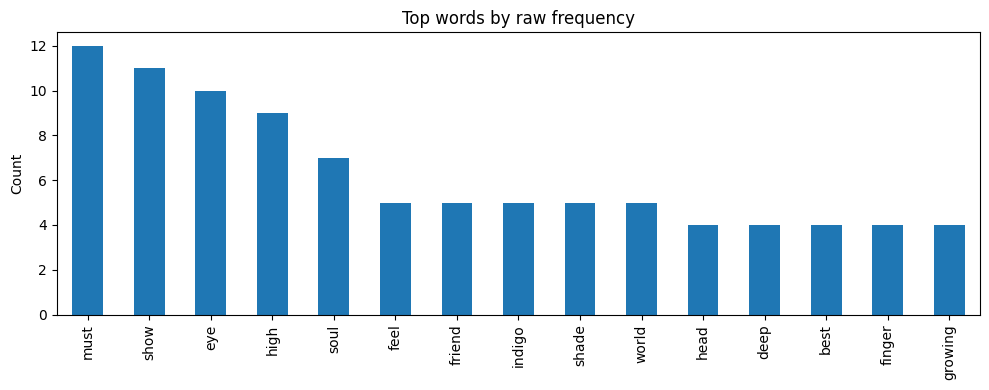

In [89]:
TOP_N = 15
term_counts = df_count.sum(axis=0).sort_values(ascending=False)
top_counts = term_counts.head(TOP_N)

plt.figure(figsize=(10, 4))
top_counts.plot(kind="bar")
plt.title("Top words by raw frequency")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Count vectorizer just counts words, so representation is direct

Word2Vec with skip-gram, vector size 100 and window 5

In [33]:
tokenized_songs = [s.split() for s in clean_songs]

w2v_model = Word2Vec(
    sentences=tokenized_songs,
    vector_size=100,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

print("Vocabulary size:", len(w2v_model.wv))

Vocabulary size: 207


Vector of document is mean embedding of all words

In [34]:
def doc_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [35]:
doc_vecs_w2v = np.vstack([doc_vector(tokens, w2v_model) for tokens in tokenized_songs])

df_w2v = pd.DataFrame(doc_vecs_w2v, index=song_labels)
df_w2v

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Song 1,-0.000576,0.000117,-0.001122,0.001928,0.000105,-0.001383,0.000158,0.001604,-0.000811,-0.000462,...,0.001015,0.001055,0.000245,0.001824,0.002286,0.000978,0.000192,-0.000830,0.000681,-0.001515
Song 2,-0.000029,-0.000190,0.000175,0.000491,-0.000895,-0.001528,0.000844,0.002793,-0.000628,-0.001411,...,0.000533,0.000909,0.000834,0.000511,0.001911,0.001656,0.000612,-0.000039,-0.000127,0.000180
Song 3,-0.001424,0.002358,0.000734,0.000253,0.001149,-0.002112,0.001425,0.002879,-0.002263,-0.000633,...,0.003269,0.000375,-0.000164,-0.001006,0.002219,0.000197,0.001266,-0.001633,-0.000558,-0.000469


Ids in w2v vectors are not connected with words like in TF-IDF and Countvectorizer, so its impossible to interprete models. On the other hand they contains context information

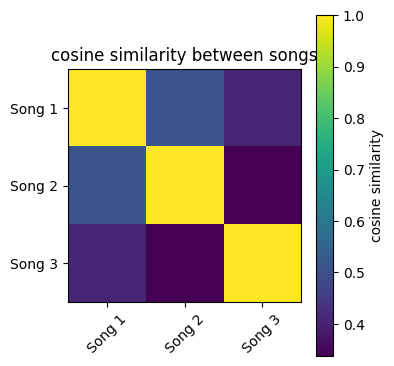

In [36]:
sim_matrix_w2v = cosine_similarity(doc_vecs_w2v)

n = len(doc_vecs_w2v)

plt.figure(figsize=(4, 4))
plt.imshow(sim_matrix_w2v, interpolation="nearest")
plt.title("cosine similarity between songs")
plt.xticks(ticks=range(n), labels=song_labels, rotation=45)
plt.yticks(ticks=range(n), labels=song_labels)
plt.colorbar(label="cosine similarity")
plt.tight_layout()
plt.show()

Word2Vec knows context, so on small dataset with only 3 songs it shows for them higher similarity

Doc2Vec. I set only 5 epochs to avoid overfitting

In [40]:
tagged_docs = [
    TaggedDocument(words=tokens, tags=[f"Song_{i}"])
    for i, tokens in enumerate(tokenized_songs)
]

d2v_model = Doc2Vec(
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=5,
    negative=10,
    dm=1
)

d2v_model.build_vocab(tagged_docs)
d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

doc_vecs_d2v = np.vstack([
    d2v_model.dv[f"Song_{i}"] for i in range(len(tokenized_songs))
])

df_d2v = pd.DataFrame(doc_vecs_d2v, index=song_labels)
df_d2v

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Song 1,-0.018110,-0.013673,-0.019869,0.017648,0.005868,-0.008427,-0.014947,0.000788,-0.017315,0.002813,...,-0.012164,0.017928,-0.019289,-0.007299,-0.000931,0.026962,0.011585,-0.010160,0.020219,0.000457
Song 2,-0.019858,-0.012048,-0.018342,0.015163,-0.005405,-0.011551,-0.006950,0.014336,-0.002375,0.004748,...,-0.014162,0.020268,-0.005161,0.009638,-0.000174,0.023524,0.015106,-0.013065,0.014792,0.004765
Song 3,-0.018267,-0.015355,0.000410,0.002727,0.010884,-0.009814,0.006275,-0.000067,-0.002294,0.005396,...,-0.011977,0.004813,-0.015775,0.002769,0.011471,0.019483,0.003967,-0.007572,0.018582,-0.007216


The same as for Word2Vec not interpretable

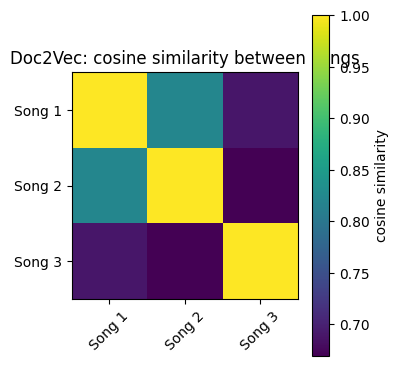

In [41]:
sim_matrix_d2v = cosine_similarity(doc_vecs_d2v)

n = len(doc_vecs_d2v)

plt.figure(figsize=(4, 4))
plt.imshow(sim_matrix_d2v, interpolation="nearest")
plt.title("Doc2Vec: cosine similarity between songs")
plt.xticks(ticks=range(n), labels=song_labels, rotation=45)
plt.yticks(ticks=range(n), labels=song_labels)
plt.colorbar(label="cosine similarity")
plt.tight_layout()
plt.show()

On small dataset even for different songs similarity is high

Comparing


In [42]:
n_docs_count, vocab_count = df_count.shape
nnz_count = np.count_nonzero(df_count.values)
sparsity_count = 1 - nnz_count / df_count.values.size

print("CountVectorizer")
print("Documents:", n_docs_count)
print("Vocabulary:", vocab_count)
print("Non-zero vals:", nnz_count)
print("Sparsity:", round(sparsity_count, 4))
print()


n_docs_tfidf, vocab_tfidf = tfidf_df.shape
nnz_tfidf = np.count_nonzero(tfidf_df.values)
sparsity_tfidf = 1 - nnz_tfidf / tfidf_df.values.size

print("TF-IDF")
print("Documents:", n_docs_tfidf)
print("Vocabulary:", vocab_tfidf)
print("Non-zero vals:", nnz_tfidf)
print("Sparsity:", round(sparsity_tfidf, 4))
print()


n_docs_w2v, dim_w2v = df_w2v.shape
print("Word2Vec:")
print("Documents:", n_docs_w2v)
print("Vector dim:", dim_w2v)
print()


n_docs_d2v, dim_d2v = df_d2v.shape
print("Doc2Vec:")
print("Documents:", n_docs_d2v)
print("Vector dim:", dim_d2v)

CountVectorizer
Documents: 3
Vocabulary: 206
Non-zero vals: 220
Sparsity: 0.644

TF-IDF
Documents: 3
Vocabulary: 206
Non-zero vals: 220
Sparsity: 0.644

Word2Vec:
Documents: 3
Vector dim: 100

Doc2Vec:
Documents: 3
Vector dim: 100


Count Vectorizer and TF-IDF showed the same parameters, because dataset is too small

CountVectorizer is just counting of words so training complexity is just O(number of documents * number of words)
TF-IDF the same
Words2Vec is small neural network so there is O(epochs * number of documents * window * dimention of embedding)
Doc2Vec the same but more vectors for document

Interpretation ability for CountVectorizer and TF-IDF is high, we can see amount of words and weight of each word. There is no semantic representation

Word2Vec and Doc2Vec have low interpretation ability but hight representation. Vectors contain information about semantic similarity of words. Similar words are near.

# Part 3

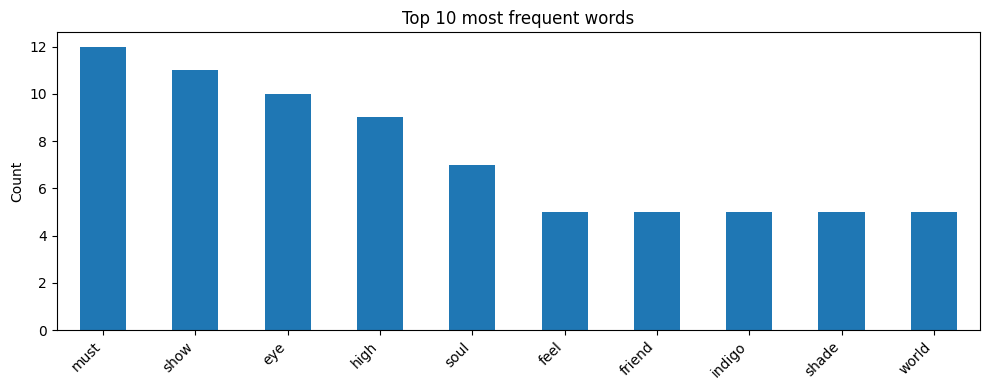

In [45]:
word_freq = df_count.sum(axis=0).sort_values(ascending=False)

top10_words = word_freq.head(10)
plt.figure(figsize=(10, 4))
top10_words.plot(kind="bar")
plt.title("Top 10 most frequent words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


There words were the most frequent in chosen songs

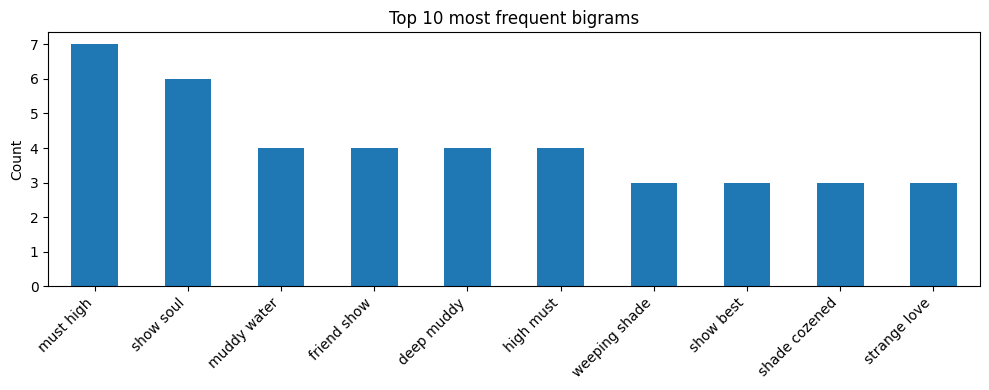

In [46]:
bigram_vec = CountVectorizer(ngram_range=(2, 2), min_df=1)
X_bigram = bigram_vec.fit_transform(clean_songs)

bigram_vocab = bigram_vec.get_feature_names_out()
bigram_counts = np.asarray(X_bigram.sum(axis=0)).ravel()

bigram_series = pd.Series(bigram_counts, index=bigram_vocab).sort_values(ascending=False)

top10_bigrams = bigram_series.head(10)

plt.figure(figsize=(10, 4))
top10_bigrams.plot(kind="bar")
plt.title("Top 10 most frequent bigrams")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Tsne according to Word2Vec words embeddings

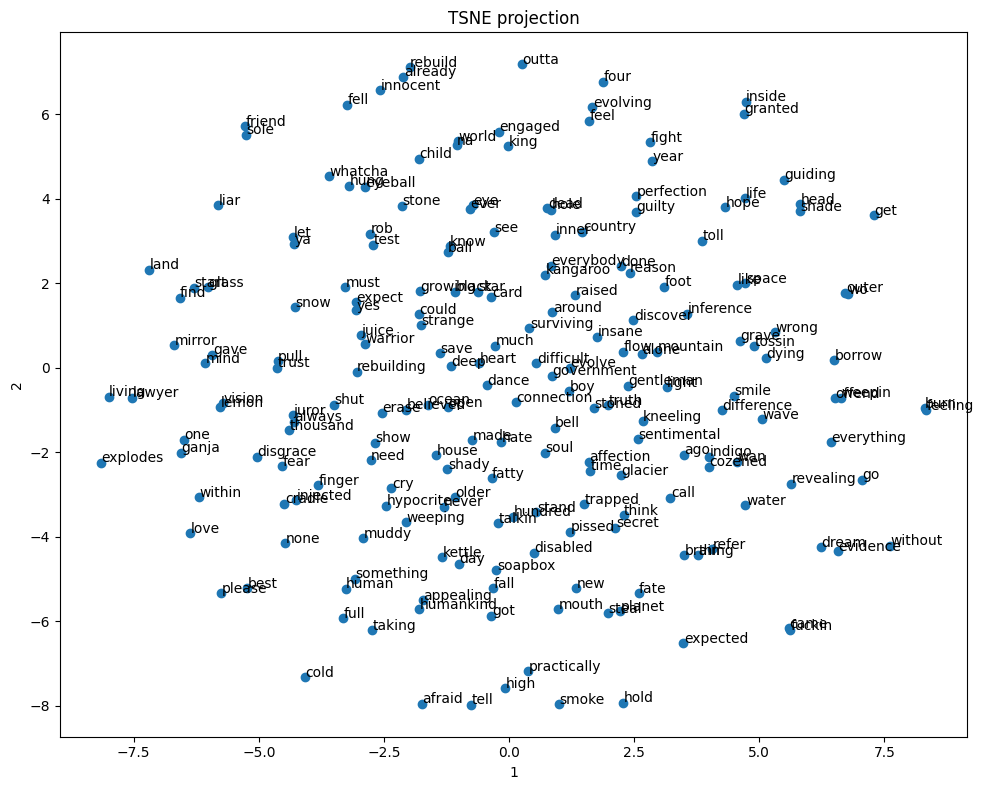

In [47]:
word_freq = df_count.sum(axis=0).sort_values(ascending=False)


valid_words = [w for w in word_freq.index if w in w2v_model.wv.key_to_index]
top_words_for_tsne = word_freq.loc[valid_words]


word_vectors = np.vstack([w2v_model.wv[w] for w in top_words_for_tsne.index])

n_words = word_vectors.shape[0]


perplexity = max(2, min(30, n_words - 1))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=42,
    init="random"
)
word_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(word_tsne[:, 0], word_tsne[:, 1])

for i, w in enumerate(top_words_for_tsne.index):
    plt.text(word_tsne[i, 0] + 0.01,
              word_tsne[i, 1] + 0.01,
              w)

plt.title("TSNE projection")
plt.xlabel("1")
plt.ylabel("2")
plt.tight_layout()
plt.show()


Words that are in the most frequent bigrams are near in tsne projection, because of logic of word2vec. If words are near - they are context of each other - they have similar embedding

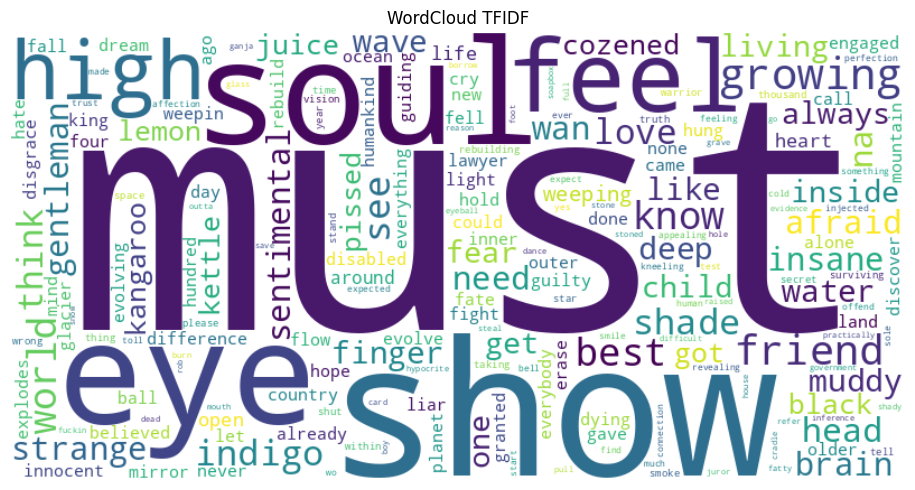

In [50]:
tfidf_sum = tfidf_df.sum(axis=0)
tfidf_freq_dict = tfidf_sum.to_dict()

wordcloud_tfidf = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate_from_frequencies(tfidf_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud TFIDF")
plt.tight_layout()
plt.show()


Important words are bigger, it can be used for example to see the most used words in chat, or the most discussed topic. In my example it just shows most important words in songs

# Part 4

Lets take 10000 rows for fast training

In [65]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df = df.head(10000)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative
9998,This is a movie that was probably made to ente...,negative


count    10000.000000
mean       231.117300
std        171.430166
min         14.000000
25%        126.000000
50%        172.000000
75%        282.000000
max       1830.000000
Name: word_count, dtype: float64


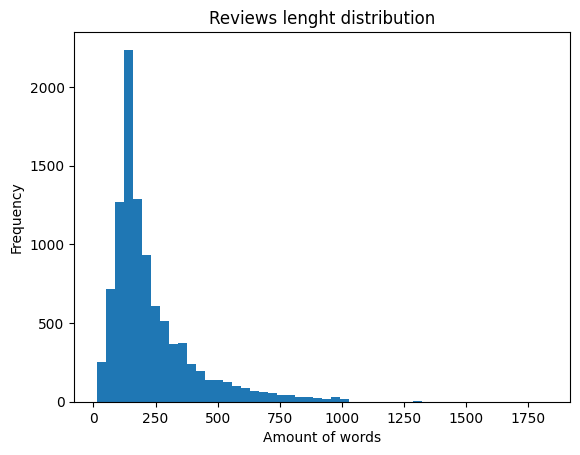

In [41]:
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

print(df["word_count"].describe())

plt.hist(df["word_count"], bins=50)
plt.xlabel("Amount of words")
plt.ylabel("Frequency")
plt.title("Reviews lenght distribution")
plt.show()

For fast training, lets set max_length to 384, it fits most songs

Text preprocessing, clean from links. Convert labels to binary

In [42]:
def clean_text(text):
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["review_clean"] = df["review"].apply(clean_text)

df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

df.head()

,review,sentiment,review_clean,label,word_count
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...,1,162
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [43]:
#Label distribution
df["label"].value_counts()

,count
label,
1,5028
0,4972


Labels are equally distributed

Test size is 20% - 2000 rows

In [44]:
train_df, test_df = train_test_split(
    df[["review_clean", "label"]],
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({
    "train": train_ds,
    "test":  test_ds,
})

Basic bert model, uncased

In [45]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Set padding to pad text to max_length and truncation to truncate it

In [46]:
max_length = 384

def tokenize_batch(batch):
    return tokenizer(
        batch["review_clean"],
        padding="max_length",
        truncation=True,
        max_length=max_length,
    )

tokenized_datasets = raw_datasets.map(tokenize_batch, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['review_clean', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['review_clean', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Remove everything except for bert required fields: inputs, attentions masks, labels and token

In [60]:
cols_to_keep = {"input_ids", "attention_mask", "label"}
cols_to_remove = [
    c for c in tokenized_datasets["train"].column_names
    if c not in cols_to_keep
]

tokenized_datasets = tokenized_datasets.remove_columns(cols_to_remove)
tokenized_datasets.set_format(type="torch")
tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Load the model to GPU and set binary classification

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Set metrics function

In [62]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="binary"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

Train the model
Batch size is large enough to train fast and fit into memory
Set basic parameters. 2 epochs is enought

In [64]:
batch_size = 32

training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=200,
    push_to_hub=False,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

/tmp/ipython-input-420611437.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.315500,0.198552,0.920500,0.930824,0.909543,0.920060
2,0.162600,0.210040,0.923000,0.930303,0.915507,0.922846


Gpu requirement was 9.7 gb

Show metrics

In [68]:
metrics = trainer.evaluate()

for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")
print(f"F1: {metrics['eval_f1']:.4f}")

eval_loss: 0.2100
eval_accuracy: 0.9230
eval_precision: 0.9303
eval_recall: 0.9155
eval_f1: 0.9228
eval_runtime: 37.8980
eval_samples_per_second: 52.7730
eval_steps_per_second: 1.6620
epoch: 2.0000
Accuracy: 0.9230
Precision: 0.9303
Recall: 0.9155
F1: 0.9228


F1 is larger than 0.9
F1 is close to accuracy, precision and recall are balanced

Lets check manually a few examples

In [69]:
def predict_sentiment(text: str):
    model.eval()
    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoded)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0]
        pred_id = torch.argmax(probs).item()

    label = "positive" if pred_id == 1 else "negative"
    confidence = probs[pred_id].item()
    return label, confidence

In [77]:
examples = [
    "This movie was absolutely fantastic, I loved every minute of it!",
    "Terrible film. Boring plot, bad acting, total waste of time.",
    "It was okay, not great, not terrible, just average, Im not sure"
]

In [78]:
for text in examples:
    label, conf = predict_sentiment(text)
    print(f"Review: {text}\nPredicted: {label} (confidence={conf:.3f})\n")

Review: This movie was absolutely fantastic, I loved every minute of it!
Predicted: positive (confidence=0.994)

Review: Terrible film. Boring plot, bad acting, total waste of time.
Predicted: negative (confidence=0.991)

Review: It was okay, not great, not terrible, just average, Im not sure
Predicted: positive (confidence=0.539)



For positive its sure, for negatife irs sure, for average review its not sure and result ~0.5

In [80]:
start = time.perf_counter()
for _ in range(10):
    predict_sentiment(examples[0])
end = time.perf_counter()

avg_time = (end - start) / 10
print(f"Average inference time per review: {avg_time:.4f} seconds")

Average inference time per review: 0.0338 seconds


I prepared data, cleaned, preprocessed it, tokenize. Prepared the model, trained it on part of the data. Results are good F1>0.9, result is stable, inference is fast < 0.04 seconds, manual test showed interbretable result